# Ryzen AI CVML Library

![](images/cvml_pipeline.png)

The Ryzen AI Computer Vision and Machine Learning (CVML) library provides optimized, ready-to-use computer vision features that can run on multiple hardware backends. 

In this notebook we'll explore depth estimation across different accelerators and measure their power efficiency.

## Goals

* Learn about the Ryzen AI CVML library
* Run depth estimation on NPU, CPU, and GPU
* Compare power consumption and performance
* Understand hardware tradeoffs for edge AI

## References

* [Ryzen AI CVML Library](https://ryzenai.docs.amd.com/en/latest/ryzen_ai_libraries.html)
* [Depth Anything V2 Paper](https://arxiv.org/abs/2406.09414)
* [RyzenAI GitHub](https://github.com/amd/RyzenAI-SW)

## What is CVML?

The Ryzen AI CVML library abstracts the complexity of running optimized computer vision models across different hardware. It provides:

- **Ready-to-use CV features**: Depth estimation, face detection, face mesh, and more
- **Optimized models**: Pre-quantized INT8 models for NPU, leveraging Depth Anything V2 architecture
- **Low power operation**: NPU provides hardware acceleration with minimal power draw

For this workshop we'll focus on **depth estimation** - estimating the distance of objects from a camera using only RGB images.

## Building CVML Samples

We've created CVML samples with prebuilt NPU and CPU backend binaries. These are minimal modifications of the official samples - differing only in the backend selection line. Let's build them:

In [1]:
!cd cvml_samples && ./build.sh

Building CVML samples...
Running CMake...
-- The C compiler identification is GNU 13.3.0
-- The CXX compiler identification is GNU 13.3.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenCV: /usr (found version "4.6.0") 
-- Found RyzenAILibrary: /ryzers/RyzenAI-SW/Ryzen-AI-CVML-Library/linux/libcvml-depth-estimation.so;/ryzers/RyzenAI-SW/Ryzen-AI-CVML-Library/linux/libcvml-face-detector.so;/ryzers/RyzenAI-SW/Ryzen-AI-CVML-Library/linux/libcvml-facemesh.so;/ryzers/RyzenAI-SW/Ryzen-AI-CVML-Library/linux/libcvml-sdk.so  
-- Configuring done (0.2s)
-- Generating done (0.0s)
-- Build files have been written to: /ryzers/noteb

## Environment Setup

Since we're running in a headless environment without a display, we need to configure Qt to use offscreen rendering. This prevents the samples from trying to open GUI windows.

In [2]:
import os
os.environ['QT_QPA_PLATFORM'] = 'offscreen'
print("Qt configured for headless mode")

Qt configured for headless mode


## Depth Estimation on a Single Image

Let's start simple - extract a single frame from the sample video and run depth estimation on it. This gives us immediate visual feedback on what depth estimation does.

### Run NPU Depth Estimation

Now let's process this frame using the NPU. The CVML library uses Depth Anything V2 models quantized to INT8 for efficient NPU execution.

[INFO] time:184715574 thread:125155296238976 AMD CVML SDK: 0.0.0-dev
[INFO] time:184715574 thread:125155296238976 Any GPU inference will use AMD Radeon Graphics (RADV GFX1151)[0]
Using NPU backend
[INFO] time:184715583 thread:125155296238976 [Depth Estimation] Using ONNX engine, NPU backend
Image file read: images/fruits.jpg
I20251023 20:56:40.334705   196 vitisai_compile_model.cpp:1143] Vitis AI EP Load ONNX Model Success
I20251023 20:56:40.334759   196 vitisai_compile_model.cpp:1144] Graph Input Node Name/Shape (1)
I20251023 20:56:40.334766   196 vitisai_compile_model.cpp:1148] 	 efficient_Unet::input_0_nhwc : [1x256x256x3]
I20251023 20:56:40.334771   196 vitisai_compile_model.cpp:1154] Graph Output Node Name/Shape (1)
I20251023 20:56:40.334774   196 vitisai_compile_model.cpp:1158] 	 2196_nhwc : [1x256x256x1]
[Vitis AI EP] No. of Operators :   CPU     2    NPU   616 
[Vitis AI EP] No. of Subgraphs :   NPU     1 Actually running on NPU     1 
[INFO] time:184725741 thread:1251550378943

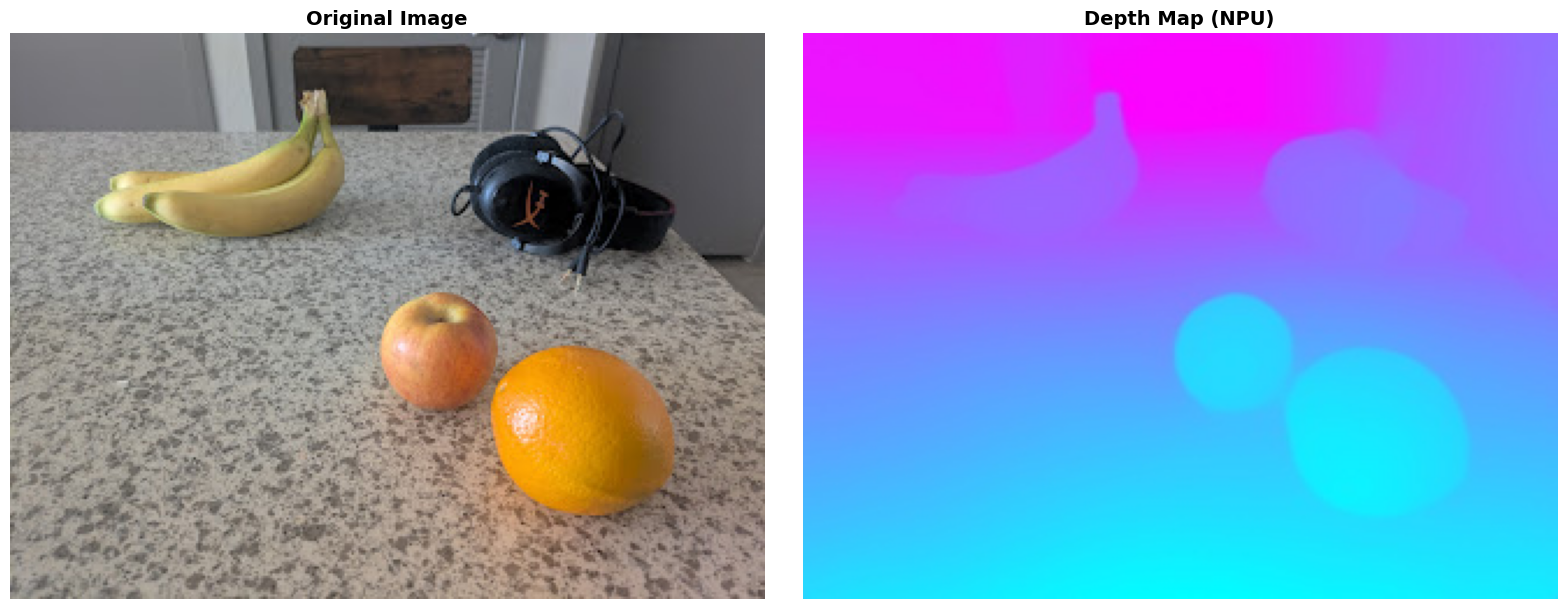

In [3]:
# Run the depth estimation sample
!sudo ./build/depth_estimation_npu -i images/fruits.jpg -o depth_npu.jpg

# Visualize the results
import cv2
import matplotlib.pyplot as plt
import numpy as np

original = cv2.imread('images/fruits.jpg')
depth = cv2.imread('depth_npu.jpg')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=14, fontweight='bold')
ax1.axis('off')

ax2.imshow(cv2.cvtColor(depth, cv2.COLOR_BGR2RGB))
ax2.set_title('Depth Map (NPU)', fontsize=14, fontweight='bold')
ax2.axis('off')

plt.tight_layout()
plt.savefig('depth_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

Depth maps use color to represent distance - in this palette the cooler blue colors represent objects that are closer, whereas red/purple represent things further away. 

## Video Processing with Power Monitoring

Now let's process the full video across different backends and monitor power consumption. This demonstrates the key advantage of the NPU - **power efficiency**.

We'll measure power using `rocm-smi` which reports socket-level power consumption. While this includes the entire APU (CPU + GPU + NPU), we can still observe relative differences between workloads.

### Power Monitoring Setup

First, let's set up our power monitoring infrastructure. We'll sample power every 500ms while the workload runs.

In [4]:
import subprocess
import threading
import time
import re

def monitor_power(power_samples, monitoring_flag):
    """Monitor power consumption using rocm-smi."""
    while monitoring_flag['active']:
        try:
            result = subprocess.run(
                ['rocm-smi', '--showpower'],
                capture_output=True,
                text=True,
                timeout=2
            )
            match = re.search(r'Power \(W\): (\d+\.\d+)', result.stdout)
            if match:
                power_samples.append(float(match.group(1)))
        except:
            pass
        time.sleep(0.5)

def run_inference_with_power(backend='npu'):
    """Run depth estimation and measure power consumption."""
    power_samples = []
    monitoring_flag = {'active': True}
    
    # Start power monitoring
    monitor_thread = threading.Thread(
        target=monitor_power, 
        args=(power_samples, monitoring_flag),
        daemon=True
    )
    monitor_thread.start()
    
    # Prepare command
    if backend == 'npu':
        cmd = ['sudo', '-E',
               './build/depth_estimation_npu',
               '-i', 'videos/video_call.mp4',
               '-o', 'output_npu.mp4']
    elif backend == 'cpu':
        cmd = ['sudo', '-E',
               './build/depth_estimation_cpu',
               '-i', 'videos/video_call.mp4', 
               '-o', 'output_cpu.mp4']
    else:  # gpu
        cmd = ['python3', 'depth_estimation_gpu_midas.py',
               '-i', 'videos/video_call.mp4',
               '-o', 'output_gpu.mp4']
    
    # Run inference
    start = time.time()
    result = subprocess.run(cmd, capture_output=True, text=True)
    duration = time.time() - start
    
    # Stop monitoring
    monitoring_flag['active'] = False
    monitor_thread.join(timeout=2)
    
    return duration, power_samples, result

### NPU Video Processing

Let's run depth estimation on the NPU and measure its power consumption.

Starting NPU depth estimation with power monitoring...

  Duration: 5.75s
  Average Power: 25.68W
  Total Energy: 147.73J


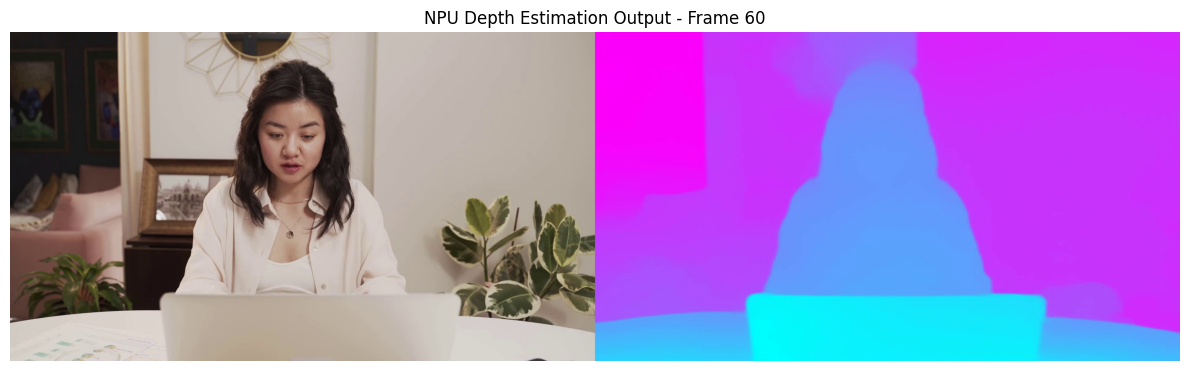

In [5]:
print("Starting NPU depth estimation with power monitoring...\n")
npu_duration, npu_power_samples, npu_result = run_inference_with_power('npu')

# Calculate statistics
npu_avg_power = np.mean(npu_power_samples)

print(f"  Duration: {npu_duration:.2f}s")
print(f"  Average Power: {npu_avg_power:.2f}W")
print(f"  Total Energy: {(npu_avg_power * npu_duration):.2f}J")

npu_stats = {
    'duration': npu_duration,
    'avg_power': npu_avg_power,
    'samples': npu_power_samples
}

# Extract and visualize a frame from the NPU output
cap = cv2.VideoCapture('output_npu.mp4')
cap.set(cv2.CAP_PROP_POS_FRAMES, 60)
ret, frame = cap.read()
cap.release()

if ret:
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title('NPU Depth Estimation Output - Frame 60')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

### CPU Video Processing

Now let's run the same workload on the CPU using ONNX Runtime.

Starting CPU depth estimation with power monitoring...

  Duration: 8.64s
  Average Power: 75.31W
  Total Energy: 650.88J


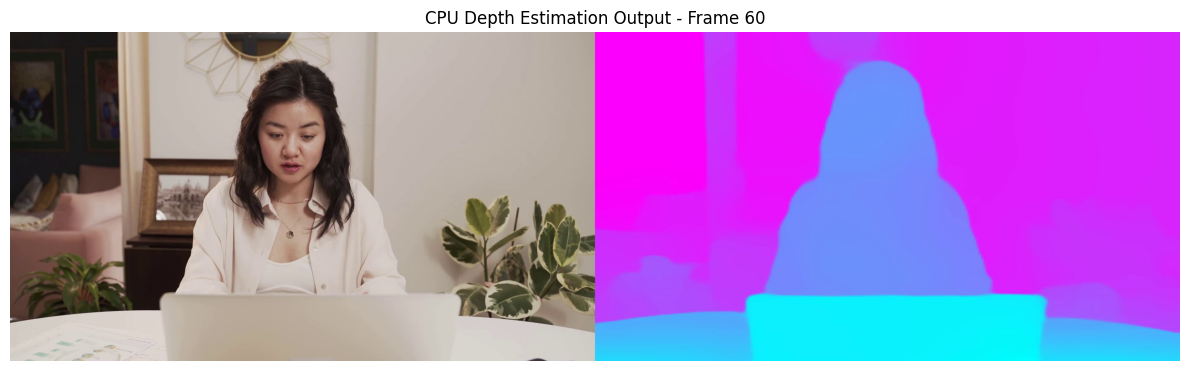

In [6]:
print("Starting CPU depth estimation with power monitoring...\n")
cpu_duration, cpu_power_samples, cpu_result = run_inference_with_power('cpu')

# Calculate statistics
cpu_avg_power = np.mean(cpu_power_samples)

print(f"  Duration: {cpu_duration:.2f}s")
print(f"  Average Power: {cpu_avg_power:.2f}W")
print(f"  Total Energy: {(cpu_avg_power * cpu_duration):.2f}J")

cpu_stats = {
    'duration': cpu_duration,
    'avg_power': cpu_avg_power,
    'samples': cpu_power_samples
}

# Extract and visualize a frame from the NPU output
cap = cv2.VideoCapture('output_cpu.mp4')
cap.set(cv2.CAP_PROP_POS_FRAMES, 60)
ret, frame = cap.read()
cap.release()

if ret:
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title('CPU Depth Estimation Output - Frame 60')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

### GPU Video Processing

Since the Linux CVML release does not currently support the GPU backend we will use an off-the-shelf depth estimator to get a realistic figure of expected performance running on a GPU. Let's run PyTorch with MiDaS - a well established small depth estimation model that should run comparatively fast on the iGPU. Check out the [depth_estimation_gpu_midas.py](depth_estimation_gpu_midas.py) script to see how it is being called.

Starting GPU depth estimation with power monitoring...

  Duration: 17.05s
  Average Power: 30.96W
  Total Energy: 527.74J


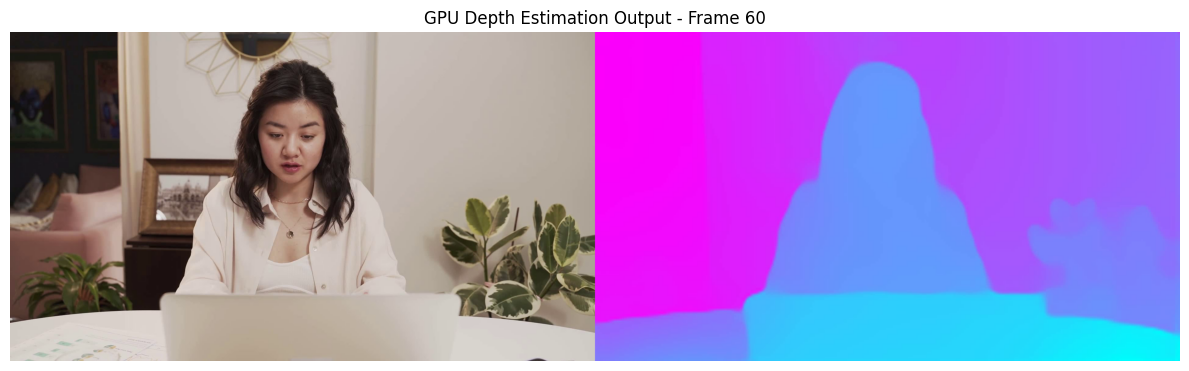

In [7]:
print("Starting GPU depth estimation with power monitoring...\n")
gpu_duration, gpu_power_samples, gpu_result = run_inference_with_power('gpu')

# Calculate statistics  
gpu_avg_power = np.mean(gpu_power_samples)

print(f"  Duration: {gpu_duration:.2f}s")
print(f"  Average Power: {gpu_avg_power:.2f}W")
print(f"  Total Energy: {(gpu_avg_power * gpu_duration):.2f}J")

gpu_stats = {
    'duration': gpu_duration,
    'avg_power': gpu_avg_power,
    'samples': gpu_power_samples
}

# Extract and visualize a frame from the NPU output
cap = cv2.VideoCapture('output_gpu.mp4')
cap.set(cv2.CAP_PROP_POS_FRAMES, 60)
ret, frame = cap.read()
cap.release()

if ret:
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title('GPU Depth Estimation Output - Frame 60')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

## Performance & Power Comparison

Now let's visualize the results to understand the tradeoffs between NPU, CPU, and GPU execution.

**Your figures might end up looking different if running on a cloud instance with fewer allocated CPUs**

**Note** this is not a proper benchmark, but a practical overview that compares the different accelerators. We can see here that the NPU performs relatively well to an off-the-shelf depth estimation model, and more importantly it does not use any GPU resources freeing it up to run more powerful AI models.

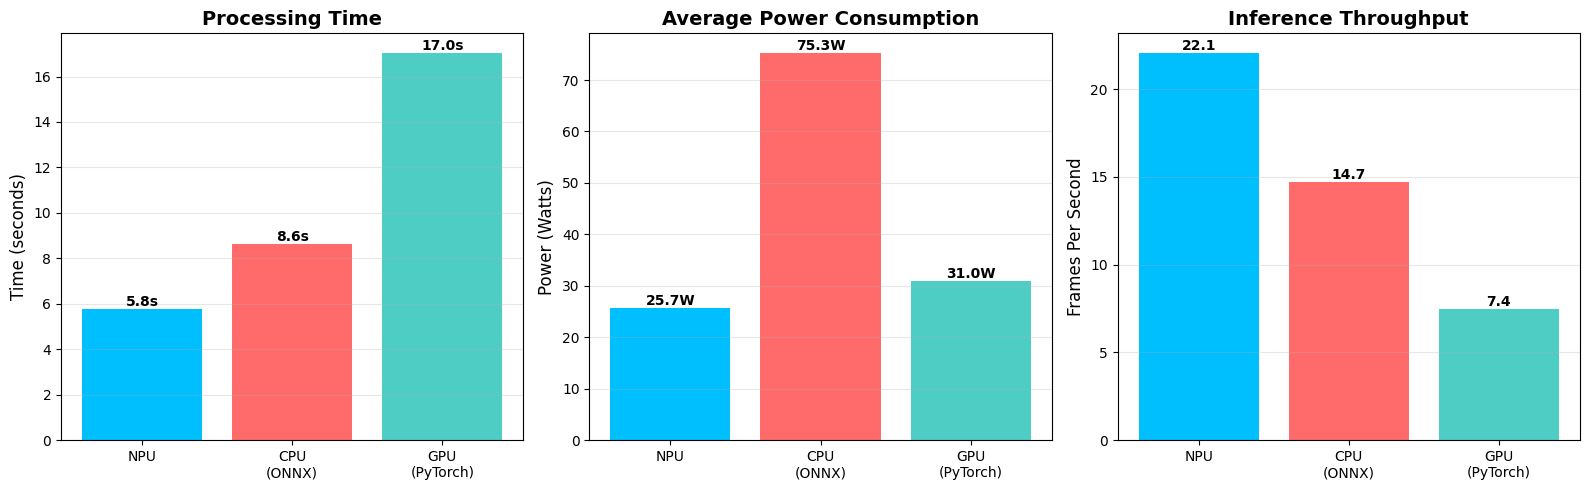

In [8]:
# Get video info for FPS calculation
cap = cv2.VideoCapture('videos/video_call.mp4')
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
cap.release()

# Calculate FPS
npu_fps = frame_count / npu_stats['duration'] if npu_stats['duration'] > 0 else 0
cpu_fps = frame_count / cpu_stats['duration'] if cpu_stats['duration'] > 0 else 0
gpu_fps = frame_count / gpu_stats['duration'] if gpu_stats['duration'] > 0 else 0

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

backends = ['NPU', 'CPU\n(ONNX)', 'GPU\n(PyTorch)']
colors = ['#00BFFF', '#FF6B6B', '#4ECDC4']

# 1. Processing Time
durations = [npu_stats['duration'], cpu_stats['duration'], gpu_stats['duration']]
axes[0].bar(backends, durations, color=colors)
axes[0].set_ylabel('Time (seconds)', fontsize=12)
axes[0].set_title('Processing Time', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(durations):
    axes[0].text(i, v, f'{v:.1f}s', ha='center', va='bottom', fontweight='bold')

# 2. Average Power
powers = [npu_stats['avg_power'], cpu_stats['avg_power'], gpu_stats['avg_power']]
axes[1].bar(backends, powers, color=colors)
axes[1].set_ylabel('Power (Watts)', fontsize=12)
axes[1].set_title('Average Power Consumption', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(powers):
    axes[1].text(i, v, f'{v:.1f}W', ha='center', va='bottom', fontweight='bold')

# 3. Throughput (FPS)
fps_values = [npu_fps, cpu_fps, gpu_fps]
axes[2].bar(backends, fps_values, color=colors)
axes[2].set_ylabel('Frames Per Second', fontsize=12)
axes[2].set_title('Inference Throughput', fontsize=14, fontweight='bold')
axes[2].grid(axis='y', alpha=0.3)
for i, v in enumerate(fps_values):
    axes[2].text(i, v, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

### Energy efficiency

We can see that using the NPU requires significantly less socket power to process the same number of frames.

In [9]:
# Print summary
print(f"Energy to process {frame_count} video frames:")
print(f"NPU (CVML):")
print(f"  └─ Energy: {(npu_stats['avg_power'] * npu_stats['duration']):.2f}J")
print(f"\nGPU (PyTorch):")
print(f"  └─ Energy: {(gpu_stats['avg_power'] * gpu_stats['duration']):.2f}J")
print(f"\nCPU (CVML):")
print(f"  └─ Energy: {(cpu_stats['avg_power'] * cpu_stats['duration']):.2f}J")

# Calculate efficiency metric (frames per joule)
npu_efficiency = frame_count / (npu_stats['avg_power'] * npu_stats['duration']) if npu_stats['avg_power'] > 0 else 0
gpu_efficiency = frame_count / (gpu_stats['avg_power'] * gpu_stats['duration']) if gpu_stats['avg_power'] > 0 else 0
cpu_efficiency = frame_count / (cpu_stats['avg_power'] * cpu_stats['duration']) if cpu_stats['avg_power'] > 0 else 0


print(f"\nEnergy Efficiency (frames/joule):")
print(f"  NPU: {npu_efficiency:.3f}")
print(f"  GPU: {gpu_efficiency:.3f}")
print(f"  CPU: {cpu_efficiency:.3f}")

Energy to process 127 video frames:
NPU (CVML):
  └─ Energy: 147.73J

GPU (PyTorch):
  └─ Energy: 527.74J

CPU (CVML):
  └─ Energy: 650.88J

Energy Efficiency (frames/joule):
  NPU: 0.860
  GPU: 0.241
  CPU: 0.195


### Power Consumption Timeline

Let's plot the power consumption over time for each backend to see how they behave during inference.

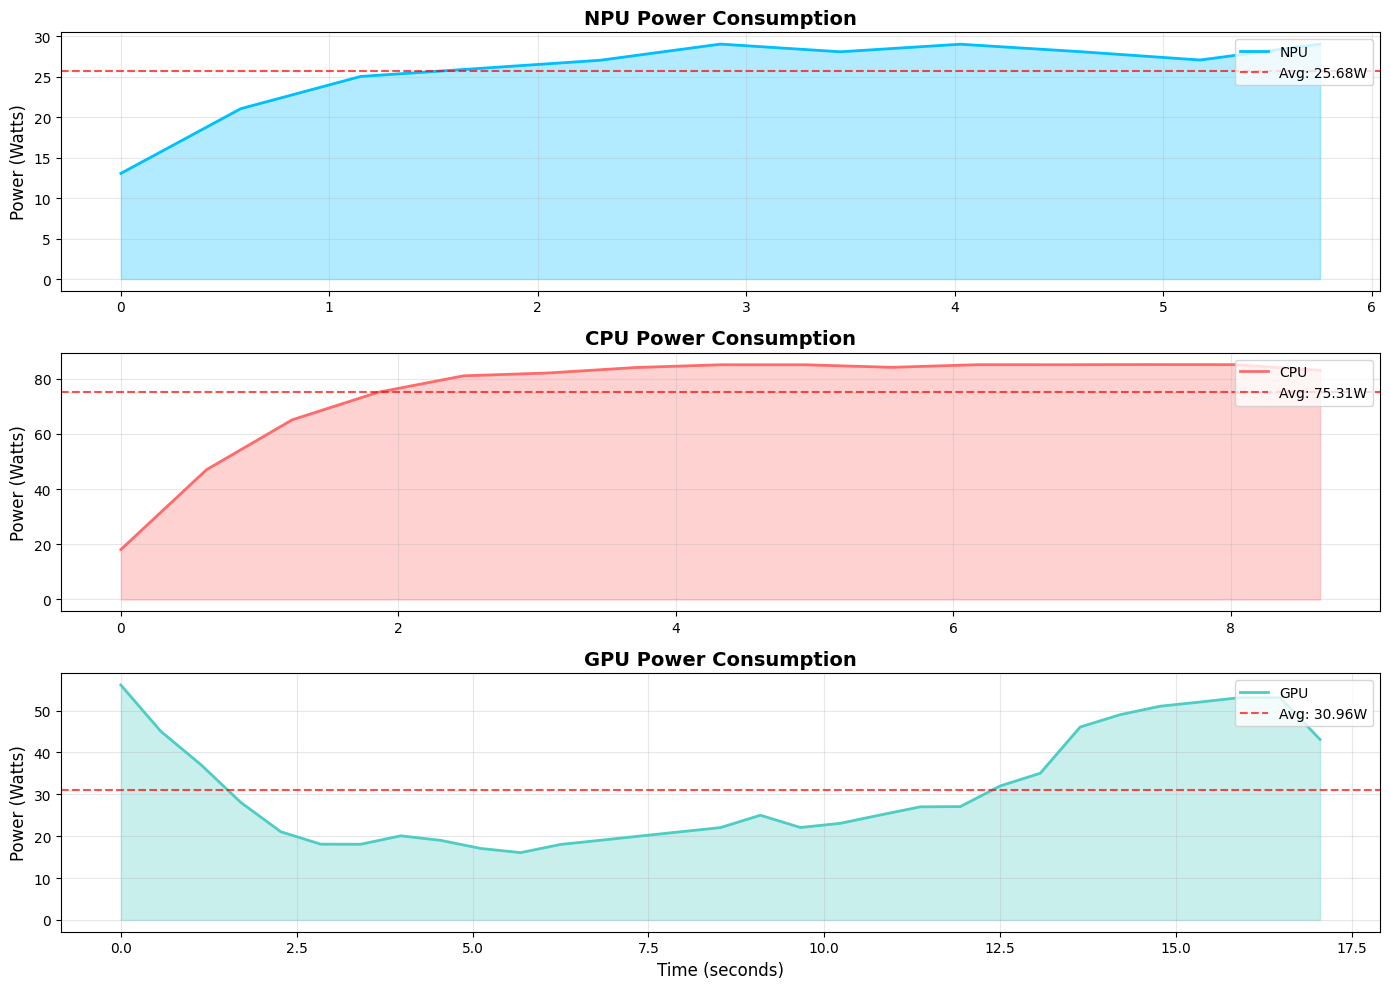

In [10]:
# Plot power consumption over time for all backends
if npu_stats['samples'] and cpu_stats['samples'] and gpu_stats['samples']:
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), sharex=False)
    
    # NPU power timeline
    npu_time = np.linspace(0, npu_stats['duration'], len(npu_stats['samples']))
    ax1.plot(npu_time, npu_stats['samples'], color='#00BFFF', linewidth=2, label='NPU')
    ax1.axhline(npu_stats['avg_power'], color='red', linestyle='--', alpha=0.7, 
                label=f'Avg: {npu_stats["avg_power"]:.2f}W')
    ax1.fill_between(npu_time, npu_stats['samples'], alpha=0.3, color='#00BFFF')
    ax1.set_ylabel('Power (Watts)', fontsize=12)
    ax1.set_title('NPU Power Consumption', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper right')
    ax1.grid(alpha=0.3)
    
    # CPU power timeline
    cpu_time = np.linspace(0, cpu_stats['duration'], len(cpu_stats['samples']))
    ax2.plot(cpu_time, cpu_stats['samples'], color='#FF6B6B', linewidth=2, label='CPU')
    ax2.axhline(cpu_stats['avg_power'], color='red', linestyle='--', alpha=0.7,
                label=f'Avg: {cpu_stats["avg_power"]:.2f}W')
    ax2.fill_between(cpu_time, cpu_stats['samples'], alpha=0.3, color='#FF6B6B')
    ax2.set_ylabel('Power (Watts)', fontsize=12)
    ax2.set_title('CPU Power Consumption', fontsize=14, fontweight='bold')
    ax2.legend(loc='upper right')
    ax2.grid(alpha=0.3)
    
    # GPU power timeline
    gpu_time = np.linspace(0, gpu_stats['duration'], len(gpu_stats['samples']))
    ax3.plot(gpu_time, gpu_stats['samples'], color='#4ECDC4', linewidth=2, label='GPU')
    ax3.axhline(gpu_stats['avg_power'], color='red', linestyle='--', alpha=0.7,
                label=f'Avg: {gpu_stats["avg_power"]:.2f}W')
    ax3.fill_between(gpu_time, gpu_stats['samples'], alpha=0.3, color='#4ECDC4')
    ax3.set_xlabel('Time (seconds)', fontsize=12)
    ax3.set_ylabel('Power (Watts)', fontsize=12)
    ax3.set_title('GPU Power Consumption', fontsize=14, fontweight='bold')
    ax3.legend(loc='upper right')
    ax3.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('power_timeline.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Power timeline not available (insufficient samples)")

## What to try next

* Experiment with your own images.
* Try running other features like face detection and face mesh.
* Check out the [depth_estimation_gpu_midas.py](depth_estimation_gpu_midas.py) script and try other sizes - the one we ran was the smallest.

In [ ]:
# Run face detection on single image
# !sudo ./build/face_detection_npu -i images/test_frame.jpg -m fast -o face_npu.jpg

## Key Takeaways

### When to Use Each Backend

- **NPU**: Best for always-on, power-constrained applications (battery-powered systems, edge devices and robot sensing).
- **GPU**: Best for maximum throughput, large AI models that require a lot of compute and memory.
- **CPU**: Fallback option for maximum compatibility, or when dedicated accelerators unavailable.

## Next Steps

Now that you understand how to use CVML and compare backends, in the next notebook we'll integrate these vision features into ROS 2 for building real robotic applications.

**Continue to**: [3_cvml_ros.ipynb](3_cvml_ros.ipynb)

## Cleanup (Optional)

Remove generated output files to save space:

In [ ]:
!rm -f output_*.mp4 depth_*.jpg face_*.jpg *.png
print("Cleanup complete!")

---
Copyright© 2025 AMD, Inc. SPDX-License-Identifier: MIT